# w261 Final Project - Clickthrough Rate Prediction


T32 <br>
Matthew Brimmer, Will Hawkins, Rahul Kulkarni, Dan Price <br>
Summer 2019, section 6   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

### Introduction

In the online advertising industry, one of the greatest challenges is to develop systems that effectively serve ads to their intended audience. Targeted advertisement systems use vast amounts of data about user behavior and preferences to determine which ads are most relevant to each user. The task of predicting advertisement click-throughs requires a solution that is (1) fast enough to handle the real-time nature of serving ads, (2) predictive enough to select ads that users will click on, and (3) scalable enough to handle vasts amounts of user data for model training and prediction. 

### Problem Statement

For this project, we’ll be exploring the targeted advertising space by developing our own supervised model to predict advertisement click-through rate (CTR). We’ll be using a large advertising dataset by Criteo that includes several anonymized fields related to the user, the webpage, and the advertisement being served at a given time. Using this data, our goal is to develop a supervised model to accurately and scalably predict the likelihood a user will click on a given ad.

This problem can be described as a probabilistic binary classification problem where the predicted output ($\hat{Y}$) is the probability that the user will click on the ad served to them. The response variable ($Y$) in our dataset is a binary variable encoded to 0 and 1 representing no-click and click, respectively. To evaluate our model’s accuracy, we will use a logarithmic loss function to compare the predicted probability that a user clicks on a given ad compared to the actual response variable (click or no-click). The logarithmic loss is averaged across all true values ($y_i$) and predicted probabilities ($\hat{y}_i$) like so:

$$LogLoss = - \frac{1}{N} \Sigma_{i=1}^N (y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i))$$

### Criteo Data

The Criteo display ad data contains a train.txt file with over 45 Million records, each representing an instance that a user was targeted with an ad by Criteo. Each record consists of 38 total features that are all unlabeled and anonymized: 13 integer fields and 26 hashed categorical fields. Each record is also given a single target value encoded as 0 and 1 to represent no-click and click, respectively. 

The Criteo data is also sub-sampled so that records with a positive ("click") target value have greater representation in the dataset. 

We're also provided a test.txt file with true target values removed, although for this project we will be creating our own validation and test data subsets from the train.txt file to evaluate our model performance.   

#### Limitations of Data 

In our EDA section, we identify several limitations with the Criteo dataset. Namely:

1. Missing values in most features
2. Extreme high cardinality in several categorical variables
3. Anonymized/hashed fields, making interpretability of features difficult
4. Target Imbalance: there is a 3-to-1 ratio of negative ("no-click") and positive ("click") target values
5. Given the anonymity of data fields, it is possible that certain integer features may represent categories

In future sections, we will discuss the design decisions that help us overcome these data limitations. 


### Evaluating Performance 

There are several ways we can estimate what level of performance our model would need to be practically useful. One way to evaluate performance is to create a baseline metric that our model must outperform. One baseline could be constructed by assuming a 50% probability of clicking for all points in our evaluation set, and using our logloss function this would result in a loss of 0.693. Using this baseline measure as a reference, we could imagine that a logloss closer to 0.5 will be practically useful. 

In addition to using the logloss metric, we will also use model evaluation metrics like F1-score, AUROC, precision, and recall as additional measures of model performance. 

### Questions To Investigate 

In an effort to guide our model development, we’ve created a list of questions that must be investigated along the way to guide our decision-making in areas related to data exploration, dimensionality reduction, and model selection. 

##### Data Exploration 

* How large is this dataset? What is the number of records and fields? What are the data types of features (integer, categorical, etc.)? This will help us gauge the magnitude and sparsity of data that our model must handle. 
* Missing values: How many missing values are there in each feature? What imputation techniques would best resolve the missing values for each feature? 
* Data cleaning: Do any features appear to have inaccurate data? If so, what data cleaning or filtering technique could address the problem? 
* For continuous variables: How are the continuous features distributed? This may impact how we decide to transform or normalize our data before training/testing our model. Certain models may need additional normalization before training. 
* For categorical variables: What is the cardinality of each feature (distinct category count)? This will help us decide which categorical encoding technique is most feasible. 
* Target Imbalance: What is the distribution of target labels? Is there a target imbalance that must be addressed? If we find that one class label is rare compared to another, we may want to rebalance the proportion of data points of each class type. 
* Feature correlation: Are any features highly correlated? Depending on our choice of model, we may need to reduce collinearity of features. 
* Target-Feature correlation: Which features are most/least correlated with the target variable? Features with low correlation with our target may want to be removed from the model. 

##### Data Preprocessing & Dimensionality Reduction
* For categorical features with high cardinality, how can we encode or transform the labels to reduce dimensionality? One-hot encoding all categories may be infeasible if there is an extremely high dimensionality of categories. Two techniques we plan to investigate include (1) feature hashing and (2) binning rare categories. For the latter technique, if we find that a small percentage of categories make up the majority of the data, we may opt to reduce dimensionality by binning-together the least common categorical values. 

##### Model Selection
* Given what we’ve learned about the data from data exploration and the need to build a model that scales well with this data, which model would achieve enough accuracy to be practically useful while maintaining scalability? 


### Sources

[1] https://www.kaggle.com/c/criteo-display-ad-challenge/



# __Section 2__ - Algorithm Explanation

### Algorithm Selection

When selecting our supervised model algorithm, we wanted to choose a model that serves our primary research question and achieves a fair balance of three qualities: (1) fast to train/test to account for the real-time nature of serving ads, (2) predictive enough to be practically useful, (3) scalable enough to handle the large size of the Criteo dataset. Furthermore, we wanted to choose algorithms that are well designed for predicting probabilities of class assignment (probabilistic classification). 

The model we ultimately chose is the widely used Logistic Regression model. Logistic Regression has several benefits that help us achieve our three aims: 
1. It is lightweight compared to other models and is less computationally expensive.
2. It's highly interpretable. Although the Criteo data fields are anonymized and hashed, we have the added benefit of being able to understand which fields impact the log odds of prediction the most. 
3. It scales well with large datasets. 
4. It requires minimal hyperparameter tuning. 
5. It requires minimal scaling of features (although scaling features does help with convergence).

That said, the Logistic Regression model does come with disadvantages. Namely:
1. We inherently assume that independent variables have a linear relationship with the log odds, while this is likely an imperfect assumption. Any non-linear relationships with the response variable will be lost. 
3. We must be careful about multicollinearity. 


### Logistic Regression Theory

Before we dive into the toy example, let’s first explain the math behind the Logistic Regression algorithm.

Logistic Regression is a common classification algorithm that is heavily based on Linear Regression. In Linear Regression, we assume that the relationship between variables is linear and that our response variable $y$ can be estimated using our input $X$ as a linear combination with weights $\theta$ like so:

$$  \hat{y}_{Linear} = Z_{Logistic} = \theta_0 + \theta_1 x_1 + … \theta_j x_j $$

Logistic regression builds on this by passing the output of this linear regression ($Z$) to a sigmoid function $g(Z)$ that smoothly maps $Z$ to values in a range between 0 and 1, representing the predicted probability of the target class ($Pr(Y==1)$). 

$$g(z) = \frac{1}{1+e^{-z}}$$

Simplifying these equations, we can represent our predicted probability ($h_{\theta}(x)$) as a function of an input $X$ like so. Ultimately, our goal is to learn the weights $\theta$ that best fit our predictor $h$ by minimizing logloss. 

$$h_{\theta}(x) = g(\theta^T x) = \frac{1}{1+e^{-\theta^T x}}$$

#### Gradient Descent

Next, we consider the process that we use to learn the ideal weights for $\theta$: Gradient Descent. The main principle behind Gradient Descent is to iteratively update the weights of $\theta$ in the direction that minimizes our loss function at each time step. 

$$ LogLoss = J(\theta) = - \frac{1}{N} \Sigma_{i=1}^N (y_i log(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i))$$

We use the loss function to evaluate our model’s performance at each step, and we use the gradient of the loss function with respect to $\theta$ to slightly update our weights, multiplied by a learning rate $\alpha$.

$$\theta_{t+1} = \theta_t - \alpha \frac{\partial}{\partial \theta} J(\theta)$$

The gradient of our logloss function simplifies to the following:

$$\frac{\partial}{\partial \theta} J(\theta) = x (h_{\theta}(x) - y)$$

And we calculate the total amount that the weights are updated by averaging the gradient value across all points $x_j$ with true values $y_j$ at each iteration. Ultimately, we update $\theta$ through enough iterations until convergence is achieved (either through a maximum number of iterations or until weights have stopped updating by some threshold).

#### Toy Data Example

Next, let's walk through the process of training a Logistic Regression model using a (very) simplified version of our Criteo dataset. Imagine we are given one integer variable "I1" and one category "C1" with the following datapoints: 

$$x_1 = \{3, dog\}$$

$$x_2 = \{1, cat\}$$

$$x_3 = \{2, dog\}$$

$$y_1 = 1$$

$$y_2 = 0$$

$$y_3 = 0$$

We can represent these data points as a 3-by-3 matrix $X$ and a 3-by-1 matrix $Y$. Notice that we remove on categorical column to prevent collinearity (in this case, we are removing the one-hot encoded column corresponding to "cat"), and we add one additional column to represent our bias term $\theta_0$ with an initial value of $1$. 

$$ X = \begin{bmatrix}
1 & 3 & 1 \\
1 & 1 & 0 \\
1 & 2 & 1 
\end{bmatrix}$$

$$ Y = \begin{bmatrix}
1 \\
0 \\
0 
\end{bmatrix}$$

Next, we want to initialize our weights $\theta$. Since there are two feature columns in $X$, our weights will have two dimensions plus one additional column to represent our bias term. 

$$\theta_{init} = \begin{bmatrix}
0 \\
0 \\
0 
\end{bmatrix}$$

Now that we've initialized our weights and prepped our data, we can begin the process of gradient descent to update our weights. Notice that each iteration requires the following steps of calculations. For the purpose of this exercise, we will perform one iteration of updating our weights with gradient descent, although in practice we would perform gradient descent until convergence (as explained above). Also note that we will be using a learning rate of value $\alpha = 0.1$. Each iteration of gradient descent consists of the following steps:

1. Calculate $Z$ using $X$ and $\theta$.
2. Calculate $h_{\theta}(X)$ using $Z$. 
3. Calculate gradient using $h_{\theta}(X)$, $X$, and $Y$.
4. Update $\theta$ using the gradient and learning rate $\alpha$. 

#### Iteration #1 

##### Step 1: Calculate $Z$ using $X$ and $\theta$: 

$$ Z = X \dot \theta_{init} = \begin{bmatrix}
1 & 3 & 1 \\
1 & 1 & 0 \\
1 & 2 & 1 
\end{bmatrix}
\begin{bmatrix}
0 \\
0 \\
0 
\end{bmatrix}
= \begin{bmatrix}
0 \\
0 \\
0 
\end{bmatrix}$$

##### Step 2: Calculate $h_{\theta}(X)$ using $Z$. 

$$h_{\theta}(X) = g(Z) = \begin{bmatrix}
\frac{1}{1+e^{-Z}} \\
\frac{1}{1+e^{-Z}} \\
\frac{1}{1+e^{-Z}} 
\end{bmatrix}
=
\begin{bmatrix}
\frac{1}{1+e^{0}} \\
\frac{1}{1+e^{0}} \\
\frac{1}{1+e^{0}} 
\end{bmatrix}
= 
\begin{bmatrix}
0.5 \\
0.5 \\
0.5
\end{bmatrix}
$$

##### Step 3: Calculate gradient for each point in $X$ using $h_{\theta}(X)$, $X$, and $Y$.

$$\nabla J_1 = (h_{\theta}(x_1) - y_1)
\begin{bmatrix}
x_{1,1}  \\
x_{1,2}  \\
x_{1,3} 
\end{bmatrix}
= 
(0.5 - 1)
\begin{bmatrix}
1  \\
3  \\
1 
\end{bmatrix}
=
\begin{bmatrix}
-0.5  \\
-1.5  \\
-0.5 
\end{bmatrix}
$$

$$\nabla J_2 = (h_{\theta}(x_2) - y_2)
\begin{bmatrix}
x_{2,1}  \\
x_{2,2}  \\
x_{2,3} 
\end{bmatrix}
= 
(0.5 - 0)
\begin{bmatrix}
1  \\
1  \\
0 
\end{bmatrix}
=
\begin{bmatrix}
0.5  \\
0.5  \\
0 
\end{bmatrix}
$$

$$\nabla J_3 = (h_{\theta}(x_3) - y_3)
\begin{bmatrix}
x_{3,1}  \\
x_{3,2}  \\
x_{3,3} 
\end{bmatrix}
= 
(0.5 - 0)
\begin{bmatrix}
1  \\
2  \\
1 
\end{bmatrix}
=
\begin{bmatrix}
0.5  \\
1  \\
0.5 
\end{bmatrix}
$$

Average each gradient vector among the three points:

$$ \nabla J = \frac{1}{3} ( 
\begin{bmatrix}
-0.5  \\
-1.5  \\
-0.5 
\end{bmatrix}
+ 
\begin{bmatrix}
0.5  \\
0.5  \\
0 
\end{bmatrix} 
+ 
\begin{bmatrix}
0.5  \\
1  \\
0.5 
\end{bmatrix} )
=
\begin{bmatrix}
0.1666  \\
0  \\
0 
\end{bmatrix}
$$

##### Step 4: Update $\theta$ using the gradient and learning rate $\alpha$. 

$$ \theta_{t=1} = \theta_{init} - \alpha \nabla J(\theta)
= 
\begin{bmatrix}
0  \\
0  \\
0 
\end{bmatrix}
- 
0.1
\begin{bmatrix}
0.1666  \\
0  \\
0 
\end{bmatrix}
= 
\begin{bmatrix}
-0.01666  \\
0  \\
0 
\end{bmatrix}
$$

At this point, we have updated our weights $\theta$ through one iteration of gradient descent. In theory, this process will continue until convergence (as explained above), although we will stop iterating now for the sake of this exercise. 

#### Predicting with our toy model

Let's now use our very basic toy model to make a test prediction. Let's use the following data point for testing purposes: 

$$x_4 = \{4, dog\}$$

$$y_4 = 1$$

Putting our test point in matrix X format (with a bias term and one-hot encoded categories) we have the following:

$$X_{test} = \begin{bmatrix}
1 & 4 & 1 
\end{bmatrix}$$

To make a prediction, we must calculate $h_{\theta}(X_{test})$ like so:

$$ Z_{test} = X_{test} \theta_{t=1} = 
\begin{bmatrix}
1 & 4 & 1 
\end{bmatrix}
\begin{bmatrix}
-0.01666 \\
0 \\
0
\end{bmatrix}
= 
-0.01666
$$

$$ h_{\theta}(X_{test}) = \frac{1}{1+e^{-Z}} = \frac{1}{1+e^{-0.01666}} = 0.5042$$

This $h$ value demonstrates that our model, as it stands, predicts $x_4$ to map to class $y=1$ with probability 0.5042. In other words, $P(y=1|x_4)=0.5042$. 

# RDD Implementation

Now that we've demonstrated the theory behind Logistic Regression, we will implement the algorithm using Spark RDDs and another toy dataset. 

First, initialize our Spark Session and context. 

In [1]:
# import libraries used in analysis
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.mllib.stat import Statistics
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# set up library autoreload
%reload_ext autoreload
%autoreload 2

# store path to notebook
PWD = !pwd
PWD = PWD[0]

# start Spark Session, Context and SQL Context
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### Toy Data 

For this RDD implementation, consider a small dataset consisting of 5 points with three columns: a 0/1 encoded target value, a categorical feature, and an integer feature. 


In [2]:
%%writefile data/toy_example.txt
0	personA 2
0	personA 1
1	personA 3
1	personB 0
0	personB 1

Overwriting data/toy_example.txt


In [3]:
# load data 
toy_data = sc.textFile("data/toy_example.txt")

We begin by defining a mapper function that parses our toy data file. This generator function tokenizes each document and emits the parsed values to be used when initializing the RDD containing our dataset. 

In [4]:
# helper function
def parse_feature(pair):
    """Mapper 2: tokenize each document and emit postings."""
    label, features = pair
    person, intval = features.split(' ')
    feature_lst = [int(intval)]
    yield((int(label), feature_lst))


Next, we define a logistic loss function (as defined in the theory section above) to help us evaluate our LR model performance through each step of gradient descent. 

In [5]:
def Logistic_Loss(dataRDD, W):
    """
    Compute Loss Function of Logistic Regression
    Args:
        dataRDD - each record is a tuple of (y, features_array)
        W   - (array) model coefficients with bias at index 0
    """
    
    # Append a bias term to the features
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[1]), x[0]))
    
    # Calculate log loss on entire dataset
    log_loss = augmentedData.map(lambda x: ( x[1] * np.log( 1/(1+math.exp(-W.dot(x[0])))) +
                    (1- x[1])*np.log(1-(1/(1+math.exp(-W.dot(x[0]))))))).mean()*-1

    return log_loss

Next, we define a function that performs an interation of gradient descent to update our model weights. This function first augments our data RDD to account for the bias term and reformats each data record to make our RDD in pair RDD format. Next, we call a map function that passes our model weights vector (W) and calculates the gradient value for each individual record. This is parallelized by performing this action on subsets of our RDD on different nodes, since each record's gradient calculation can be calculated separately. After the map call to calculate individual gradients, we calculate the mean value of all gradient values and update our model weights to be returned. 

In [7]:
def GDUpdate(dataRDD, W, learningRate = 1):
    """
    Perform one gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    
    # bias term at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[1]), x[0])).cache()
    
    # Calculate mean gradient 
    grad = augmentedData.map(lambda x: (((1/(1+math.exp(-W.dot(x[0])))) - x[1])*x[0])).mean()
    
    # Update model 
    new_model = W - learningRate * grad
    
    return new_model

### Running our RDD Implementation

Below, we put the pieces together for our RDD implementation and perform gradient descent for 75 iterations on our toy dataset. 

In [8]:
%%time
# take a look at a few Gradient Descent steps
VERBOSE = False

# Initialize weights to zeros
BASELINE_MODEL = np.zeros(2)

# Parse and tokenize features to initialize data RDD
result = toy_data.map(lambda line: line.split('\t')) \
            .flatMap(parse_feature)

# GD iterations
nSteps = 75
model = BASELINE_MODEL
print("BASELINE:  Loss =", Logistic_Loss(result,model))
for idx in range(nSteps):
    if VERBOSE:
        print("----------")
        print("STEP:", idx+1)
        
    # 
    model = GDUpdate(result, model)
    loss = Logistic_Loss(result, model)
    if VERBOSE:
        print("Loss:", loss)
        print("Model:", [round(w,3) for w in model])

print('Final Values:')
print('Num Steps: ', nSteps)
print("Loss:", loss)
print("Model:", [round(w,3) for w in model])

BASELINE:  Loss = 0.6931471805599452
Final Values:
Num Steps:  75
Loss: 0.6698095194581317
Model: [-0.629, 0.158]
CPU times: user 1.48 s, sys: 360 ms, total: 1.84 s
Wall time: 20.5 s


### Sources

[1] http://cs229.stanford.edu/notes/cs229-notes1.pdf

[2] https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf

[3] https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

# __Section 3__ - EDA & Challenges

### __Section 3.1__ Setup

We start our analyis by importing the usual suspects of libraries from the data scientist toolbox. Our intent is to leverage the power of PySpark and its machine learning library to build our click through rate prediction pipeline. We make the pipeline design choice to adopt PySpark SQL as our data structure of choice because of the syntax parallels to the ubiquitious Pandas data model. As we explore below, we make use of the power of Pandas in our exploratory data analysis on subsets of the larger dataset. The final stage in our setup is initialization of our Spark session, context, and SQL context.

### __Section 3.2__ Command Line Exploration

Even before we begin to examine our data with PySpark, the command line offers a convenient location to begin our data exploration. The wordcount command line utility offers a quick peek at statistics that will be used throughout our analysis. Specifically, we can see that the test.txt file has just over 6 million records while the train.txt file has well over 45 million records. 

The head command provides a visual reference for individual records in our data. The train data has 14 numeric columns followed by 26 hashed categorical values. The first of the numeric columns is the binary label where a value of 0 refers to not clicked while 1 is clicked. Thus, for our model we consider 13 integer features and 26 categorical features. The README file distributed with the data informs the first column is removed from the test data. Because the test data is meant for competition scoring purpose, we set it aside and focus our analysis on the train data.

In [2]:
!echo "Wordcount of test.txt:"
!wc data/test.txt
!echo ""

!echo "First row of data from test.txt:"
!head -n 1 data/test.txt
!echo ""

!echo "Wordcount of train.txt"
!wc data/train.txt
!echo ""

!echo "First row of data from train.txt:"
!head -n 1 data/train.txt

Wordcount of test.txt:
   6042135  202864503 1460246311 data/test.txt

First row of data from test.txt:
	29	50	5	7260	437	1	4	14		1	0	6	5a9ed9b0	a0e12995	a1e14474	08a40877	25c83c98		964d1fdd	5b392875	a73ee510	de89c3d2	59cd5ae7	8d98db20	8b216f7b	1adce6ef	78c64a1d	3ecdadf7	3486227d	1616f155	21ddcdc9	5840adea	2c277e62		423fab69	54c91918	9b3e8820	e75c9ae9

Wordcount of train.txt
   45840617  1579300947 11147184845 data/train.txt

First row of data from train.txt:
0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


### __Section 3.3__ Data Reading and Preprocessing

PySpark offers convenient methods for ingesting our tab delimited data into dataframes. In order to conveniently query and reference data columns by name despite the absense of feature semantics, we increment the identifier "i" for integers and "c" for categorical columns. 

In [3]:
start = time.time()
print('Reading trainDF to Spark ...')
trainDF = sqlContext.read.format('csv') \
    .options(header='false', inferschema='true') \
    .option("delimiter", "\t") \
    .load('data/train.txt')
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print('Reading testDF to Spark ...')
testDF = sqlContext.read.format('csv') \
    .options(header='false', inferschema='true') \
    .option("delimiter", "\t") \
    .load('data/test.txt')
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print('Relabeling dataframe column names ...')
base_integer_col_name = 'i'
base_categorical_col_name = 'c'
label_name = 'label'

n_int_cols = 13
n_cat_cols = 26

int_col_names = [base_integer_col_name + str(i) for i in range(n_int_cols)]
cat_col_names = [base_categorical_col_name + str(i) for i in range(n_cat_cols)]

newColNames = [label_name] + int_col_names + cat_col_names
#update column names on trainDF
for old_col_name,new_col_name in zip(trainDF.columns,newColNames):
    trainDF=trainDF.withColumnRenamed(old_col_name,new_col_name)

testColNames = int_col_names + cat_col_names
#do same for testDF
for old_test_col_name,new_test_col_name in zip(testDF.columns,testColNames):
    testDF=testDF.withColumnRenamed(old_test_col_name,new_test_col_name)
    
print(f'... completed job in {time.time() - start} seconds.')

Reading trainDF to Spark ...
... completed job in 129.7505111694336 seconds.
Reading testDF to Spark ...
... completed job in 17.367038249969482 seconds.
Relabeling dataframe column names ...
... completed job in 0.5436818599700928 seconds.


### __Section 3.4__ Data Storage

We heed instructor recommendation and save our data to parquet files. We profit from the quick and convenient read of the parquet files at time of analysis. Parquet format is favorable for compression benefits and I/O reduction due to scanning only subset of columns when reading the data. 

As we validated our algorithms, we found it useful to partition the data into smaller chunks. We sampled the full dataset at sampling ratios of 0.006 and 0.3 to get smaller datasets useful for EDA and pipeline development. Data is chronologically ordered. To avoid a bias from sampling just a contingous time block, we do a random sample of the training dataset.

In [4]:
# verify data not already written
!rm -rf data/testDF.parquet
!rm -rf data/trainDF.parquet
!rm -rf data/trainDF_miniTrain.parquet
!rm -rf data/trainDF_miniValidation.parquet
!rm -rf data/trainDF_mediumTrain.parquet
!rm -rf data/trainDF_mediumValidation.parquet

# write to parquet
start = time.time()
print('Writing data/testDF.parquet ...')
testDF.write.parquet("data/testDF.parquet")
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print('Writing data/trainDF.parquet ...')
trainDF.write.parquet("data/trainDF.parquet")
print(f'... completed job in {time.time() - start} seconds.')
    
# CREATE SMALL DATASETS FOR QUICK ITERATION
train, validation = trainDF.sample(False, 0.006, seed=42).randomSplit([0.8, 0.2], seed=42)

start = time.time()
print('Writing data/trainDF_miniTrain.parquet ...')
train.write.parquet("data/trainDF_miniTrain.parquet")
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print('Writing data/trainDF_miniValidation.parquet ...')
validation.write.parquet("data/trainDF_miniValidation.parquet")
print(f'... completed job in {time.time() - start} seconds.')

# CREATE BIGGER DATASETS FOR TRAINING AND VALIDATION (OF ORIGINAL TRAINING SET)
# WILL MAKE THIS FULL DATASET FOR RUNNING IN CLOUD
train, validation= trainDF.sample(False, 0.3, seed=42).randomSplit([0.8, 0.2], seed=42)

start = time.time()
print('Writing data/trainDF_mediumTrain.parquet ...')
train.write.parquet("data/trainDF_mediumTrain.parquet")
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print('Writing data/trainDF_mediumValidation.parquet ...')
validation.write.parquet("data/trainDF_mediumValidation.parquet")
print(f'... completed job in {time.time() - start} seconds.')

Writing data/testDF.parquet ...
... completed job in 40.52037239074707 seconds.
Writing data/trainDF.parquet ...
... completed job in 229.3202142715454 seconds.
Writing data/trainDF_miniTrain.parquet ...
... completed job in 87.97745990753174 seconds.
Writing data/trainDF_miniValidation.parquet ...
... completed job in 87.95877861976624 seconds.
Writing data/trainDF_mediumTrain.parquet ...
... completed job in 132.07092881202698 seconds.
Writing data/trainDF_mediumValidation.parquet ...
... completed job in 116.05112147331238 seconds.


In [12]:
# INPUT_PARQUET_TRAIN_FILE = 'data/trainDF.parquet'
INPUT_PARQUET_TRAIN_FILE, INPUT_PARQUET_VAL_FILE = 'data/trainDF_miniTrain.parquet', 'data/trainDF_miniValidation.parquet'
# INPUT_PARQUET_TRAIN_FILE, INPUT_PARQUET_VAL_FILE = 'data/trainDF_mediumTrain.parquet', 'data/trainDF_mediumValidation.parquet'

print('Reading trainDF from parquet for analysis ...')
trainDF = sqlContext.read.parquet(INPUT_PARQUET_TRAIN_FILE)
valDF = sqlContext.read.parquet(INPUT_PARQUET_VAL_FILE)

# trainDF = trainDF.fillna(0)

Reading trainDF from parquet for analysis ...


In [13]:
from pyspark.sql.functions import col, lit, when, isnull, broadcast

for col in ['i' + str(i) for i in range(n_int_cols)]:
    trainDF = trainDF.withColumn(col, trainDF[col].cast('float'))
    valDF = valDF.withColumn(col, valDF[col].cast('float'))


### __Section 3.5__ Click Through Rate Label Distribution

A logical step in exploratory data analysis for the advertising dataset is to understand and visualize the distribution of the classes. The dataframe lends itself well to simple counting of the binary label column. From this knowledge, we assemble the step of counting, percentage tally, and visualization into a reusable function.

A simple analysis of the click through rate reveals the skew of the data. Yet, despite a dataset that demonstrates clear bias for the "no click" class, it appears worth noting that oversampling of the click class was done in advance of our downloading of the data. A blog from an online advertising firm suggests the average click through rate across all industries is 1.91%[1]. From this statistic, we can see why it was in the interest of the data distributor to build oversampling of the click class into the dataset. Also, for this reason, we do not alter the sample distribution of the data for our model.

Source:<br>
[1] Average Click-Through Rates in Google Ads by Industry. https://www.wordstream.com/blog/ws/2010/04/26/good-click-through-rate.

In [21]:
def plt_clicks(inputDF):
    
    click_count = inputDF[inputDF['label'] == 1].count()
    no_click_count = inputDF[inputDF['label'] == 0].count()
    total_count = inputDF.count()
    percent_click = click_count/total_count
    percent_no_click = no_click_count/total_count
    
    action = ['click','no click']
    action_axis = np.arange(len(action))
    action_count = [inputDF[inputDF['label'] == 1].count(), inputDF[inputDF['label'] == 0].count()]
    
    plt.bar(action_axis, action_count, align='center', alpha=0.5)
    plt.xticks(action_axis, action)
    plt.ylabel('Count')
    plt.title('Label Count')
    plt.show()
    
    print(f'Total number of clicks:    {click_count}')
    print(f'Total number of no clicks: {no_click_count}')
    print(f'Total number of records:   {total_count}')    
    print(f'Click percentage:          {percent_click*100:.2f}%')
    print(f'No click percentage:       {percent_no_click*100:.2f}%')

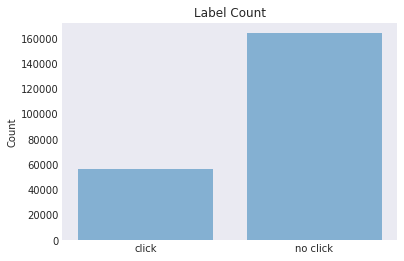

Total number of clicks:    56146
Total number of no clicks: 163984
Total number of records:   220130
Click percentage:          25.51%
No click percentage:       74.49%
... completed job in 4.985145568847656 seconds.


In [22]:
start = time.time()
plt_clicks(trainDF)
print(f'... completed job in {time.time() - start} seconds.')

### __Section 3.6__ Click Through Rate Feature Distribution

Despite undisclosed semantic understanding of the data columns, an understanding of the distribution of the features is a necessary step in our exploratory data analysis. We start by exploring the range of distinct values in each feature. Insight regarding conceivable characteristics of our features become apparent. For example, feature i9 is coded as an integer but it only has 10 distinct values according to our distinct value counting function. It may be that feature i9 is a categorical preprocessed to an integer because the categories reflect degree that can be appropriately coded on a scale containing 10 distinct values. Additionally, we might expect that integer valued features would have more distinct values in comparison to most categorical features. Yet, we note features like categorical feature c3 with 46,392 distinct value possibilities. Observations such as these, lead us to consider techniques meant to reduce feature space.

In [23]:
def get_distinct_counts(inputDF):
    start = time.time()
    distinct_counts = {}
    for column_name in inputDF.schema.names:
        #if column_name not in ['c2','c11','c15','c20']:
        distinct_counts[column_name] = len(inputDF.select(column_name).distinct().collect())
        print(column_name,distinct_counts[column_name])
    print(f'... completed job in {time.time() - start} seconds.')

In [25]:
get_distinct_counts(trainDF)

label 2
c0 792
c1 531
c2 94114
c3 46392
c4 177
c5 13
c6 9478
c7 347
c8 3
c9 17311
c10 4363
c11 85645
c12 3046
c13 26
c14 6704
c15 69542
c16 10
c17 3123
c18 1503
c19 4
c20 78927
c21 12
c22 14
c23 19347
c24 59
c25 14725
i0_cast_to_float 191
i1_cast_to_float 3393
i2_cast_to_float 926
i3_cast_to_float 112
i4_cast_to_float 36829
i5_cast_to_float 2402
i6_cast_to_float 830
i7_cast_to_float 148
i8_cast_to_float 2022
i9_cast_to_float 9
i10_cast_to_float 105
i11_cast_to_float 98
i12_cast_to_float 208
... completed job in 47.82199311256409 seconds.


### __Section 3.7__ Bins for Categorical Features

To reduce dimensionality, we seek to determine if a small number of distinct values within categories make up a large percent of the data. For this stage of the analysis, we use a small subset of the original train data. We arbitrarily set 90% as the threshold of distinct values that we aim to include within our model.

In [10]:
pdf = trainDF.toPandas()
cat_cols = ['c'+str(i) for i in range(n_cat_cols)]
cat_top_90pct_vals = {}
# {column: [values to get to 90%]}
for col in cat_cols:
    top_values = pdf[col].value_counts(dropna=False, normalize=True).cumsum().reset_index().iloc[0:100]
    # how many distinct to get 90% of values?
    if max(top_values[col].values >= 0.9):
        num = top_values[top_values[col].values>0.9].index[0]+1
        print(f'Column {col} took {num} values for 90%')
        cat_top_90pct_vals[col] = top_values.iloc[0:num,0].values.tolist()

print('Final Dictionary To Collapse Categoricals:', cat_top_90pct_vals)
# If value is not in dictionary, aggregate and treat as separate group
# pdf.shape

Column c0 took 10 values
Column c4 took 4 values
Column c5 took 4 values
Column c7 took 5 values
Column c8 took 2 values
Column c13 took 5 values
Column c16 took 7 values
Column c18 took 50 values
Column c19 took 4 values
Column c21 took 3 values
Column c22 took 6 values
Column c24 took 8 values
Final Dictionary To Collapse Categoricals: {'c0': ['05db9164', '68fd1e64', '5a9ed9b0', '8cf07265', 'be589b51', '5bfa8ab5', '87552397', 'f473b8dc', '39af2607', 'ae82ea21'], 'c4': ['25c83c98', '4cf72387', '43b19349', '384874ce'], 'c5': ['7e0ccccf', 'fbad5c96', 'fe6b92e5', nan], 'c7': ['0b153874', '5b392875', '1f89b562', '37e4aa92', '062b5529'], 'c8': ['a73ee510', '7cc72ec2'], 'c13': ['b28479f6', '07d13a8f', '1adce6ef', '64c94865', 'cfef1c29'], 'c16': ['e5ba7672', '07c540c4', 'd4bb7bd8', '3486227d', '776ce399', '27c07bd6', '8efede7f'], 'c18': [nan, '21ddcdc9', '55dd3565', '5b885066', '9437f62f', '712d530c', 'cf99e5de', '1d1eb838', 'efa3470f', '4764bf77', '1d04f4a4', '3014a4b1', '04de9d96', 'a153ce

In [14]:
cat_top_90pct_vals = {'c0': ['05db9164', '68fd1e64', '5a9ed9b0', '8cf07265', 'be589b51', '5bfa8ab5', '87552397', 'f473b8dc', '39af2607', 'ae82ea21'], 'c4': ['25c83c98', '4cf72387', '43b19349', '384874ce'], 'c5': ['7e0ccccf', 'fbad5c96', 'fe6b92e5', np.nan], 'c7': ['0b153874', '5b392875', '1f89b562', '37e4aa92', '062b5529'], 'c8': ['a73ee510', '7cc72ec2'], 'c13': ['b28479f6', '07d13a8f', '1adce6ef', '64c94865', 'cfef1c29'], 'c16': ['e5ba7672', '07c540c4', 'd4bb7bd8', '3486227d', '776ce399', '27c07bd6', '8efede7f'], 'c18': [np.nan, '21ddcdc9', '55dd3565', '5b885066', '9437f62f', '712d530c', 'cf99e5de', '1d1eb838', 'efa3470f', '4764bf77', '1d04f4a4', '3014a4b1', '04de9d96', 'a153cea2', '6f3756eb', '338f20de', '9653bb65', 'f30f7842', '2b558521', '064f1f80', 'e3b5ceb7', 'a34d2cf6', '083e89d9', '26e97973', '7a45f7f2', '315ba0e1', '2f4b9dd2', '0053530c', 'a18beb4f', 'b87498e2', '07995af6', '4632bcdc', '5b5de845', '75916440', '92524a76', 'd9aa05dc', 'fc134659', '0ec8d23c', 'e22752c5', '609029d1', 'c7dc6720', '8733cf72', 'd0289910', 'e5e1bbb7', '23a4bfcf', 'a8ac0fc0', '276c2365', '85684dc0', 'f44bef3c', '5d097c5a'], 'c19': [np.nan, 'b1252a9d', '5840adea', 'a458ea53'], 'c21': [np.nan, 'ad3062eb', 'c9d4222a'], 'c22': ['32c7478e', '3a171ecb', '423fab69', 'bcdee96c', 'be7c41b4', 'c7dc6720'], 'c24': [np.nan, '001f3601', 'e8b83407', 'ea9a246c', 'cb079c2d', '445bbe3b', '9b3e8820', '2bf691b1']}

### __Section 3.8__ Correlation Matrix for Integer Features

It is worth time spent taking a look at correlation between features as well as feature correlation with the label. Concerning the former, we aim to limit multicollinearity by eliminating features too closely related. We also evaluate the correlation coefficient of features with the label to access the value of including the feature in the model.

In [4]:
def build_corelation_matrix(inputDF):
    col_names = inputDF.schema.names[0:12]
    features = inputDF.rdd.map(lambda row: row[0:12])
    corr_mat= Statistics.corr(features, method="pearson")
    corr_df = pd.DataFrame(corr_mat)
    corr_df.index, corr_df.columns = col_names, col_names
    # print(corr_df.to_string())
    return corr_df

def plot_correlation_heatmap(corr_mat):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5});

Calculating correlation matrix ...
... completed job in 1138.8357419967651 seconds.


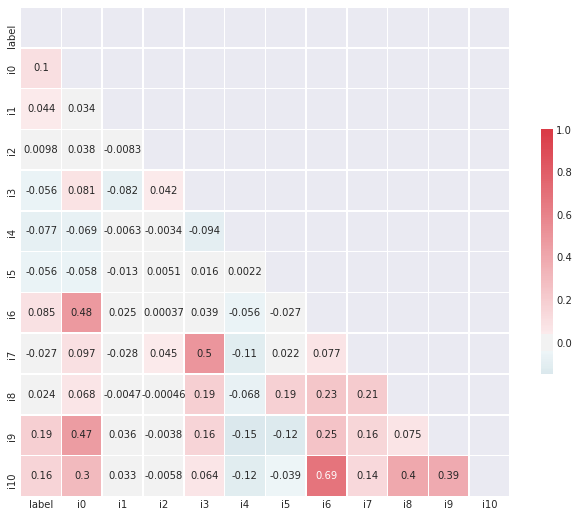

In [5]:
start = time.time()
print('Calculating correlation matrix ...')
plot_correlation_heatmap(build_corelation_matrix(trainDF)) # full train dataset
print(f'... completed job in {time.time() - start} seconds.')

### __Section 3.9__ Missing Values

Missing values is another aspect of the dataset that requires our attention. We first take several steps to characterize the nature of the missing values. We see that missing values occur in high number (thousand to hundreds of thousands) in many of the columns. We note that missing values occur in the integer-valued and categorical columns. The percentage of missing values gives us further insight into the distribution of missing values among some of the columns. We consider several strategies for missing values including filling with default value, using a mean-strategy imputer, or using NumPy not-a-number as a known category. 

In [14]:
def plot_missing(inputDF):
    missing_train = inputDF.isnull().sum()
    missing_train = missing_train[missing_train > 0]
    missing_train.sort_values(inplace=True)
    missing_train.plot.bar()

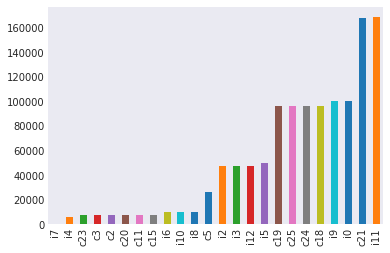

In [15]:
plot_missing(pdf)

In [18]:
def percent_missing(data):
    # Find the total NA-valued data and sort by descending order.
    total = data.isnull().sum()
    total_sorted = total.sort_values(ascending=False)
    
    # Calculate the percent of missing data.
    percent = (data.isnull().sum() / data.isnull().count())
    percent_sorted = percent.sort_values(ascending=False)
    
    # find features with most missing values.
    missing_data = pd.concat([total_sorted, percent_sorted], axis=1, keys=['Total Missing', 'Percent of Missing values'])
    print(missing_data.head(10))  

In [19]:
percent_missing(pdf)

     Total Missing  Percent of Missing values
i11         168665                   0.766206
c21         168029                   0.763317
i0           99872                   0.453696
i9           99872                   0.453696
c25          96554                   0.438623
c24          96554                   0.438623
c19          96554                   0.438623
c18          96554                   0.438623
i5           49549                   0.225090
i3           47595                   0.216213


### __Section 3.10__ Integer Variable Summary

While we are working with the sampled dataset in Pandas, we would be remiss if we did not generate descriptive statistics of our integer-valued columns. An analysis of the distribution of values is helpful. We take an interesting interpretative note about column i1 in that it is the only numeric column it seems to have negative values. We are led to believe that most of the numeric values are counts. A negative value is reason to be suspicious of this column. We also note that i4 has consistently large values relative to the other values. Similarly, columns i9 and i11 have fractional mean values and zero-valued quartiles. 

We discussed several strategies for integer variables. We debated the possibility of taking log values for some or all columns to offset the right skew of many of the columns as evidenced in the histogram. We also discussed the possibility of eliminating extreme values to generate a more uniform distribution. We also considered the merits of binning the integers in quadrants - essentially converting them to categoricals to have a purely categorical model. Because of our lack of semantic understanding of the columns, we focused our efforts instead on a strategy to bin the categoricals.

In [37]:
pdf[int_col_names].describe()

,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12
count,120258.000000,220130.000000,173055.000000,172535.000000,2.145020e+05,170581.000000,210448.000000,220023.000000,210448.000000,120258.000000,210448.000000,51465.000000,172535.000000
mean,3.486837,105.664884,27.958060,7.332738,1.867433e+04,116.834753,15.791640,12.532890,104.991665,0.614412,2.692152,0.965044,8.257727
std,9.333972,390.383116,407.039227,8.774638,7.000240e+04,374.197020,58.900059,18.956486,216.746880,0.680082,5.081437,4.748035,18.478557
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,3.280000e+02,8.000000,1.000000,2.000000,10.000000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,3.000000,6.000000,4.000000,2.819000e+03,33.000000,3.000000,7.000000,38.000000,1.000000,1.000000,0.000000,4.000000
75%,3.000000,35.000000,18.000000,10.000000,1.016200e+04,103.000000,11.000000,19.000000,109.000000,1.000000,3.000000,1.000000,10.000000
max,411.000000,16653.000000,65535.000000,370.000000,2.197840e+06,55134.000000,5257.000000,3998.000000,13533.000000,8.000000,134.000000,206.000000,3754.000000


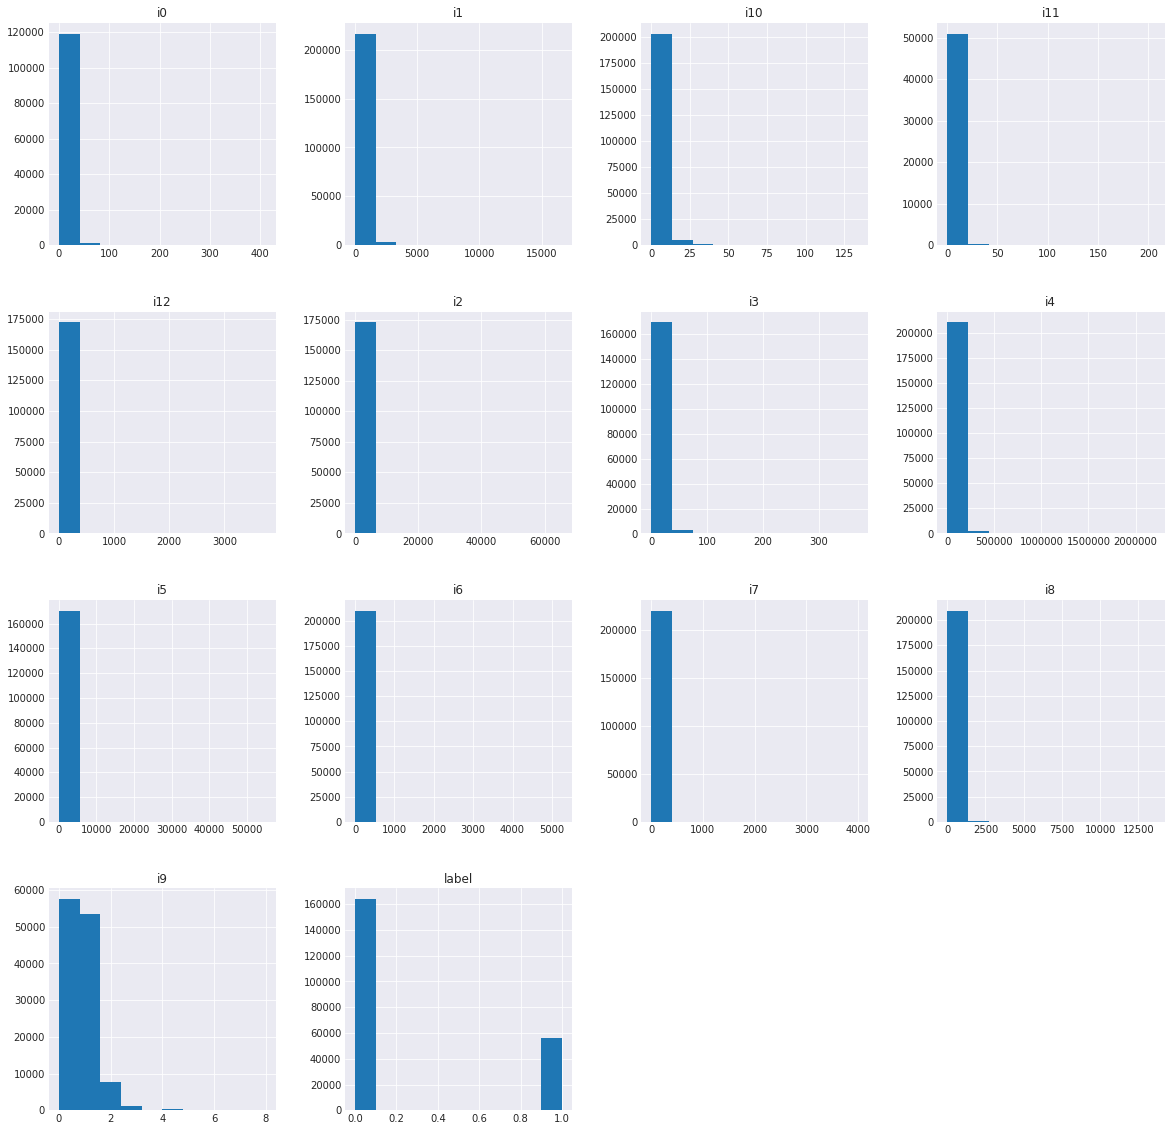

In [20]:
col_names = [label_name] + int_col_names
toyDFI = pdf[col_names]
toyDFI.hist(figsize=(20,20))
plt.show()

# __Section 4__ - Algorithm Implementation

### Spark Implementation
* We are implementing the design in Spark, leveraging the pyspark library. We utilize dataframes which add a layer of abstraction to the spark RDDs and allow the data to be distributed among the worker nodes in the cluster, thus allowing us to process a file that is potentially larger than what would fit on a single machine. (Scaling out rather than up).
* Note these subsequent cells work through a local implementation built to be run on a single node computer, but we have a single cell further down that is built to refence google cloud data files and be run on a dataproc cluster.

### Categorical Binning
* As discussed above, in order to eliminate some dimensionality while maintaining our interpretability goals, we chose to keep widly used categories within the categorical columns. Columns where a small subset of distinct values couldn't describe the column were removed. (see section 3.7 for more discussion of this methodology)
* We considered a feature hashing approach to reducing the dimensionality, but this would have eliminated our ability to explain the categorical output so we ultimately decided against it.
* The way we implement this in practice is via a map-side join, broadcasting the values for each column that we wish to keep within the dataframe (the remainder would be put into an "other" bin.

### Integer Feature Preprocessing
* As discussed above, because the data readme file indicated the integers were mostly count features, we are treating them as numeric in this iteration. Future enhancements may be made we may bin by treating them differently (binning, etc.). Missing values are being filled via imputation of the mean. We discussed either omitting the variables filling with zero, or imputing with median. The downside of the mean imputation is that it can be skewed by outliers which do exist in the dataframe. This is a known and understood concern and one that future iterations will delve into the impact of adjusting.
    
### Pipeline
* Managing the complex operations being done for preprocessing and learning of the models is made simple via the use of pipelines. The transformations and estimations being applied to the training set could be easily
* Becuase they simplify the bookkeeping of all the operations (transformations and estimations) being done to the data, pipelines facilitate quick iteration with new models, enhancements, feature selection techniques, normalization, etc.
* Pipeline Component: STRING INDEXING / ONE-HOT ENCODING
 * Operating on the categories and columns that survived from the categorical binning, we leverage the spark StringIndexer and OneHotEncoder to first map these strings to label indices and then to one-hot encode the values into columns.

In [18]:
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
from pyspark.ml.pipeline import Transformer
from pyspark.sql.functions import col, lit, when, isnull, broadcast

 # ADJUST CATEGORICAL VARIABLES (BIN / KEEP ONLY SPECIFIC COLS)

def categorical_binning(df):
    for c in cat_col_names:
        if c not in cat_top_90pct_vals.keys():
            df = df.drop(c)
        else:
            # bin only the top values, call rest 'other'
            # broadcast (map-side join) makes this run significantly faster
            vals = sqlContext.createDataFrame(cat_top_90pct_vals[c], StringType()).cache()
            df = df.join(broadcast(vals), (df[c] == vals.value), how='left')

            # keep matches -- convert non-match to 'other'
            new_column_2 = when(
                col(c).isNull() & col("value").isNull(), 'null'
            ).when(col(c) == col("value"), col('value')).otherwise('other')
            df = df.withColumn(c+"_adj", new_column_2).drop('value')
    return df

trainDF = categorical_binning(trainDF)
valDF = categorical_binning(valDF)

In [6]:
cat_top_90pct_vals = {'c0': ['05db9164', '68fd1e64', '5a9ed9b0', '8cf07265', 'be589b51', '5bfa8ab5', '87552397', 'f473b8dc', '39af2607', 'ae82ea21'], 'c4': ['25c83c98', '4cf72387', '43b19349', '384874ce'], 'c5': ['7e0ccccf', 'fbad5c96', 'fe6b92e5', np.nan], 'c7': ['0b153874', '5b392875', '1f89b562', '37e4aa92', '062b5529'], 'c8': ['a73ee510', '7cc72ec2'], 'c13': ['b28479f6', '07d13a8f', '1adce6ef', '64c94865', 'cfef1c29'], 'c16': ['e5ba7672', '07c540c4', 'd4bb7bd8', '3486227d', '776ce399', '27c07bd6', '8efede7f'], 'c18': [np.nan, '21ddcdc9', '55dd3565', '5b885066', '9437f62f', '712d530c', 'cf99e5de', '1d1eb838', 'efa3470f', '4764bf77', '1d04f4a4', '3014a4b1', '04de9d96', 'a153cea2', '6f3756eb', '338f20de', '9653bb65', 'f30f7842', '2b558521', '064f1f80', 'e3b5ceb7', 'a34d2cf6', '083e89d9', '26e97973', '7a45f7f2', '315ba0e1', '2f4b9dd2', '0053530c', 'a18beb4f', 'b87498e2', '07995af6', '4632bcdc', '5b5de845', '75916440', '92524a76', 'd9aa05dc', 'fc134659', '0ec8d23c', 'e22752c5', '609029d1', 'c7dc6720', '8733cf72', 'd0289910', 'e5e1bbb7', '23a4bfcf', 'a8ac0fc0', '276c2365', '85684dc0', 'f44bef3c', '5d097c5a'], 'c19': [np.nan, 'b1252a9d', '5840adea', 'a458ea53'], 'c21': [np.nan, 'ad3062eb', 'c9d4222a'], 'c22': ['32c7478e', '3a171ecb', '423fab69', 'bcdee96c', 'be7c41b4', 'c7dc6720'], 'c24': [np.nan, '001f3601', 'e8b83407', 'ea9a246c', 'cb079c2d', '445bbe3b', '9b3e8820', '2bf691b1']}

In [19]:
# **********************************
# ********* SET UP PIPELINE ********
# **********************************

stages = []
# ********** PIPELINE FOR NUMERIC COLUMNS ************
from pyspark.ml.feature import Imputer, OneHotEncoderEstimator, StringIndexer, VectorAssembler, FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

numerical_cols = ['i' + str(i) for i in range(n_int_cols)]
numerical_imputed_cols = [var + '_imputed' for var in numerical_cols]

imputer_for_cast_vars = Imputer(inputCols = numerical_cols, outputCols = numerical_imputed_cols, strategy='mean')
stages += [imputer_for_cast_vars]

# imputer_for_cast_vars.fit(trainDF).transform(trainDF).take(2)

# ********** PIPELINE FOR CATEGORICAL COLUMNS ************
categoricalColumns = cat_top_90pct_vals.keys()
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index', handleInvalid='keep')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_classVec"])
    stages += [stringIndexer, encoder]
    
# hasher = FeatureHasher(inputCols=categoricalColumns, outputCol="features_hashed", numFeatures = 2^10)

# ********** PUT TOGETHER ************    
features = numerical_imputed_cols +  [var + "_classVec" for var in categoricalColumns]
vector_assembler = VectorAssembler(inputCols = features, outputCol= "features")
stages+=[vector_assembler]

# ********** GENERATE MODEL ************    
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
stages += [lr]

pipeline = Pipeline(stages = stages)


# **********************************
# ********* FIT / TRAIN PIPELINE ********
# **********************************

lrModel = pipeline.fit(trainDF)

# **********************************
# ********* RUN ON OUT OF SAMPLE ********
# **********************************
predictions = lrModel.transform(valDF)


# Calculate Log Loss
firstelement=udf(lambda v:float(v[1]),FloatType())
predictions = predictions.withColumn('prob_single_val', firstelement('probability'))
predictions = (     
    predictions.withColumn('logloss', 
         -F.col('label')*F.log(F.col('prob_single_val')) - (1.-F.col('label'))*F.log(1.-F.col('prob_single_val')))
              )

logloss = predictions.agg(F.mean('logloss').alias('ll')).collect()[0]['ll']

In [21]:
# **********************************
# ********* Evaluate Predictions ********
# **********************************

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

def evaluate(predictionAndLabels):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], float(line[0])))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))
    log['Log Loss:'] = logloss
    print('Log Loss =  {:.4f}'.format(logloss))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'], 
                    log[label]['recall'], log[label]['F1 Measure']))
    
    return log

evaluate(predictions)

Area under ROC = 0.709744
Area under PR = 0.443845
[[39535.  1581.]
 [11941.  2111.]]
[Overall]	precision = 0.7548941415313225 | recall = 0.7548941415313225 | F1 Measure = 0.7548941415313225
Log Loss =  0.5248
[Class 0.0]	precision = 0.7680278187893387 | recall = 0.9615478159354023 | F1 Measure = 0.8539614653533784
[Class 1.0]	precision = 0.5717768147345612 | recall = 0.15022772559066325 | F1 Measure = 0.23793958521190262


{'AUROC': '0.709744',
 'AUPR': '0.443845',
 'precision': '0.7548941415313225',
 'recall': '0.7548941415313225',
 'F1 Measure': '0.7548941415313225',
 'Log Loss:': 0.5248267170573159,
 0.0: {'precision': '0.7680278187893387',
  'recall': '0.9615478159354023',
  'F1 Measure': '0.8539614653533784'},
 1.0: {'precision': '0.5717768147345612',
  'recall': '0.15022772559066325',
  'F1 Measure': '0.23793958521190262'}}

The recall for the 'Clicked' or 1.0 value stands out as very low (although we don't have a true baramoter for what 'good' would be). A more complete discussion of this is below (in Results / Model Improvement section).

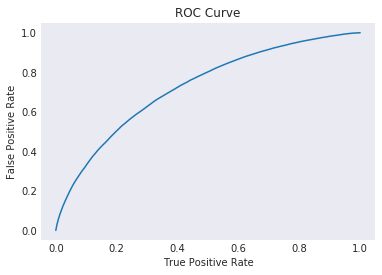

Training set areaUnderROC: 0.725589017617367


In [149]:
# **********************************
# ********* ROC CURVE ********
# **********************************
trainingSummary = lrModel.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

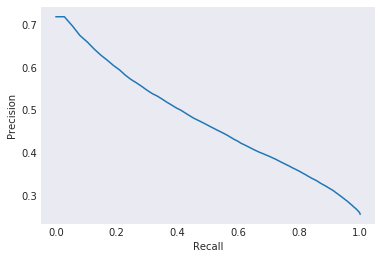

In [118]:
# **********************************
# ********* PRECISION VS RECALL ********
# **********************************
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# __Scale Implementation for GCP__ 

Above this point we have a working spark pipeline tested on a smaller dataset. We take our model and convert it to a GCP pyspark job to run on a scaled cluster setup. To run this on GCP first we modified a few notable properties:
1. Increased the memory on the spark driver and the executor to 26G and 8G respectively
2. Used n1-highmem-4 machines that have 4 vCPUS and 26G of memory
3. Used 4 worker and 1 master node

We made a decision to copy the parquet files to the GCP bucket for our train and test data

The code below writes out a file called gcpjob.py which we use to submit the job to a GCP cluster. Out implemetation below took 26 Minutes to complete on the cluster setup.


In [11]:
%%writefile gcpjob.py
###############
#GCP JOB
###############

########## UPLOAD PARQUET ##################
#To upload to GCP bucket use this command
#gsutil -m cp -r data/trainDF.parquet  gs://ucb-w261-rk/
############################################

#!/usr/bin/env python

import re
import ast
import time
import math
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import col, lit, when, isnull, broadcast
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer, OneHotEncoderEstimator, StringIndexer, VectorAssembler, FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import udf

## Create a Spark Session
spark = SparkSession.builder \
        .getOrCreate()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

############## YOUR BUCKET HERE ###############
BUCKET="ucb-w261-rk"
############## (END) YOUR BUCKET ###############

n_int_cols = 13
n_cat_cols = 26


int_col_names = ['i' + str(i) for i in range(n_int_cols)]
cat_col_names = ['c' + str(i) for i in range(n_cat_cols)]

#################### COPY these to your bucket ######################
#gsutil -m cp -r data/trainDF_miniTrain.parquet gs://ucb-w261-rk/
#gsutil -m cp -r data/trainDF_miniValidation.parquet gs://ucb-w261-rk/
INPUT_PARQUET_TRAIN_FILE = "gs://"+BUCKET+"/trainDFparquet"
#######################################################################

# (HARD-CODED DICTIONARY IS FROM ABOVE EDA)
cat_top_90pct_vals = {'c0': ['05db9164', '68fd1e64', '5a9ed9b0', '8cf07265', 'be589b51', '5bfa8ab5', '87552397', 'f473b8dc', '39af2607', 'ae82ea21'], 'c4': ['25c83c98', '4cf72387', '43b19349', '384874ce'], 'c5': ['7e0ccccf', 'fbad5c96', 'fe6b92e5', np.nan], 'c7': ['0b153874', '5b392875', '1f89b562', '37e4aa92', '062b5529'], 'c8': ['a73ee510', '7cc72ec2'], 'c13': ['b28479f6', '07d13a8f', '1adce6ef', '64c94865', 'cfef1c29'], 'c16': ['e5ba7672', '07c540c4', 'd4bb7bd8', '3486227d', '776ce399', '27c07bd6', '8efede7f'], 'c18': [np.nan, '21ddcdc9', '55dd3565', '5b885066', '9437f62f', '712d530c', 'cf99e5de', '1d1eb838', 'efa3470f', '4764bf77', '1d04f4a4', '3014a4b1', '04de9d96', 'a153cea2', '6f3756eb', '338f20de', '9653bb65', 'f30f7842', '2b558521', '064f1f80', 'e3b5ceb7', 'a34d2cf6', '083e89d9', '26e97973', '7a45f7f2', '315ba0e1', '2f4b9dd2', '0053530c', 'a18beb4f', 'b87498e2', '07995af6', '4632bcdc', '5b5de845', '75916440', '92524a76', 'd9aa05dc', 'fc134659', '0ec8d23c', 'e22752c5', '609029d1', 'c7dc6720', '8733cf72', 'd0289910', 'e5e1bbb7', '23a4bfcf', 'a8ac0fc0', '276c2365', '85684dc0', 'f44bef3c', '5d097c5a'], 'c19': [np.nan, 'b1252a9d', '5840adea', 'a458ea53'], 'c21': [np.nan, 'ad3062eb', 'c9d4222a'], 'c22': ['32c7478e', '3a171ecb', '423fab69', 'bcdee96c', 'be7c41b4', 'c7dc6720'], 'c24': [np.nan, '001f3601', 'e8b83407', 'ea9a246c', 'cb079c2d', '445bbe3b', '9b3e8820', '2bf691b1']}

## Load function
def load(path):
    # Load DataFrame
    df = sqlContext.read.parquet(path)

    # ADJUST NUMERIC FEATURES (MAKE FLOAT TO IMPUTE LATER)
    for c in int_col_names:
        df = df.withColumn(c, df[c].cast('float'))

    # ADJUST CATEGORICAL VARIABLES (BIN / KEEP ONLY SPECIFIC COLS)

    for c in cat_col_names:
        if c not in cat_top_90pct_vals.keys():
            df = df.drop(c)
        else:
            # bin only the top values, call rest 'other'
            
            vals = sqlContext.createDataFrame(cat_top_90pct_vals[c], StringType()).cache()
            df = df.join(broadcast(vals), (df[c] == vals.value), how='left')

            # keep matches -- convert non-match to 'other'
            new_column_2 = when(
                col(c).isNull() & col("value").isNull(), 'null'
            ).when(col(c) == col("value"), col('value')).otherwise('other')
            df = df.withColumn(c+"_adj", new_column_2).drop('value')
    
    train, test= df.randomSplit([0.8, 0.2], seed=42)
    return train, test

## Create a spark pipeline
def create_pipeline(trainDF):
    stages = []
    # ********** PIPELINE FOR NUMERIC COLUMNS ************
    numerical_cols = ['i' + str(i) for i in range(n_int_cols)]
    numerical_imputed_cols = [var + '_imputed' for var in numerical_cols]

    imputer_for_cast_vars = Imputer(inputCols = numerical_cols, outputCols = numerical_imputed_cols, strategy='mean')
    stages += [imputer_for_cast_vars]

    # imputer_for_cast_vars.fit(trainDF).transform(trainDF).take(2)

    # ********** PIPELINE FOR CATEGORICAL COLUMNS ************
    categoricalColumns = cat_top_90pct_vals.keys()
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index', handleInvalid='keep')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "_classVec"])
        stages += [stringIndexer, encoder]

    # ********** PUT TOGETHER ************    
    features = numerical_imputed_cols +  [var + "_classVec" for var in categoricalColumns]
    vector_assembler = VectorAssembler(inputCols = features, outputCol= "features")
    stages+=[vector_assembler]

    # ********** GENERATE MODEL ************    
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
    stages += [lr]

    pipeline = Pipeline(stages = stages)
    lrModel = pipeline.fit(trainDF)
    
    return lrModel

def create_predictions(pipeline, df):
    predictions = pipeline.transform(df)
    return predictions


def evaluate(predictionAndLabels, pipeline):
    # Add in log loss -- only works where we have label
    firstelement=udf(lambda v:float(v[1]),FloatType())
    predictionAndLabels = predictionAndLabels.withColumn('prob_single_val', firstelement('probability'))
    predictionAndLabels = ( 
        predictionAndLabels.withColumn('logloss', -F.col('label')*F.log(F.col('prob_single_val')) - (1.-F.col('label'))*F.log(1.-F.col('prob_single_val')))
                  )

    logloss = predictionAndLabels.agg(F.mean('logloss').alias('ll')).collect()[0]['ll']
    
    log = {}

    # Show Validation Score (AUROC)
    log['# Obervations'] = predictionAndLabels.count()
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], float(line[0])))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))
    log['Log Loss:'] = logloss
    print('Log Loss =  {:.4f}'.format(logloss))
    
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'], 
                    log[label]['recall'], log[label]['F1 Measure']))

    return log


trainDF, testDF = load(INPUT_PARQUET_TRAIN_FILE)
lr_pipeline = create_pipeline(trainDF)
predictions = create_predictions(lr_pipeline, testDF)
log = evaluate(predictions, lr_pipeline)

print('************ LOG OUTPUT **************:', log)
print('************ END LOG OUTPUT **************:')


Overwriting gcpjob.py


## Submit GCP job command ##

```python submit_job_to_cluster.py --project_id=${PROJECT_ID} \
         --zone=us-central1-b --cluster_name=barf \
         --gcs_bucket=${BUCKET} --key_file=$HOME/w261.json \
         --create_new_cluster \
         --pyspark_file=/Users/kulkarnir/mids/w261-11-16/main/Assignments/FinalProject/gcpjob.py \
         --instance_type=n1-highmem-4 --worker_nodes=4```


## Results / Model Improvements / Next Steps

After running our Spark pipeline on GCP with the full dataset, we achieved the following results, as indicated in our GCP log output (which can be found in `gcpjob.log`). Here are our evaluation metrics of our model on the held-out test set of 20% of the full training data (9M records). 

Metric | Score
--- | ---
Log Loss | 0.5144
F1 Measure | 0.7567
Area under ROC | 0.7159
Area under PR | 0.4614

Class | Precision | Recall | F1 Measure
--- | --- | --- | ---
Class “0” | 0.7663 | 0.9681 | 0.8555
Class “1” | 0.6076 | 0.1433 | 0.2319

While our Log Loss and overall F1 Measure is fair for our purposes, we notice one major issue with our model performance. We see that the recall for Class 1 ("click") is very low, especially compared to the recall for Class 0 ("no click"). A recall value this low indicates that we aren't correctly labeling a very high percentage of the true clicks. 

Potential Reasons for suboptimal performance:
Because we chose a simple linear model when the reality is likely that there are many non-linearities, we are likely suffering from a high bias issue. If our goal was to simply maximize the F1 score, we would have chosen a different model (non-linear, perhaps a tree-based approach). Part of our goal was to have interpretability, which we have maintained at the expense of decreased performance metrics. 

Potential solutions for future iterations to address the performance issues: 
1. Bring in more features. We are limiting our usage of categorical variables only to those that have relatively few discrete uses. We could explore increasing the number of values each could take on to increase the feature space and complexity.
2. Transform the integer variables. While we are currently treating them as counts (because the information about them indicates that they are almost all counts, we may still want to explore binning them by quantile, etc. so we have fewer outliers, as the histograms indicate we have significant spreads.
3. Imbalanced Data: One of the reasons that our Class 1 Recall is so low is that we have an imbalace of target value representation in our dataset. The ratio of no-click to click values is 3:1. We could consider down-sampling the majority class and over sampling the minority class to improve the recall and F1-measure of our Class 1 predictions. However since down-sampling may result in loss of information we could consider the BRF (Balanced Random Forest) approach or a Weighted Random Forest approach. 

### Sources
[1] https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
   
[2] https://www.adrian.idv.hk/2018-01-24-downsample/
   
[3] https://www.smartinsights.com/internet-advertising/internet-advertising-analytics/display-advertising-clickthrough-rates/

# __Section 5__ - Course Concepts

This project offered a chance to explore several class concepts in greater detail.

#### One-Hot Encoding / Feature Selection

We discussed the idea of one-hot encoding as a solution for the document similarity task. One-hot encoding gives us a numerical vector representation for features that are not numeric in their baseline representation. In the vector, 1-s and 0-s represent the presence or absense of a term. The categorical values that we structured into our pipeline are an example of non-numeric features that benefit from codification of one-hot representation. As warned in our homework 3 workbook, the implementation of a pipeline with one-hot encoding significantly increased our feature space [1]. We had to make a thorough assessment of the number of distinct categories for each of the categorical variables in our decision to apply one-hot encoding.

#### Normalization
Normalization was discussed in Week 5 as a technique to put numeric feature dimensions on a "more equal footing". Normalization is accomplished by subtracting the mean of a feature from a value and dividing the difference by the feature standard deviation [2]. We debated normalization of the numeric features in our model. However, with the exception of one numeric feature, we were fairly convinced that the numeric features were counts. Given the assumption of the same type of variable across most columns, we opted against normalization.

#### Broadcasting / caching
With large dataframes, a standard join is a very expensive operation because they require that matched keys from each dataframe be located on the same partition to be combined locally. Unless the dataframes or RDDs have the same partitioner, a shuffle would be necessary to get keys together. To get around this issue, we used a map-side join to aid with the binning / keeping of only the top categories. [3]
 
#### Scale
A big challenge in running these large datasets using a spark pipeline was to tailor our implementation to the availability of the resources in GCP. The key to understanding how to scale and do ML is to understand the relationship between these three vectors Compute, Memory, Network of a cluster in relation to the requirements of our implementation. Given that some of the resource constraints such as total available memory in the spark driver for a particular iteration of our implementation was greater that the available memory in a given node then we'd either had to change the type of the machine with a larger memory footprint or change our implementation to fit witin the aggregated memory constraint given to us. The choice between having multiple workers vs larger workers which essentially is scale out vs scale up. The goal was to find a reasonable balance and a sweet spot to make sure that our algorithm can complete in a reasonable amount of time given the resources and at the same time keep our implemtation simple.  This exercise highilights the challenges faced specifically for large scale workloads given a finite number of resources. We would have liked to spend more time optimizing the implmentation and observe how it relates to the infrastructure being utilized and also understand the bottlenecks in terms of the usage ratios of compute:memory:storage:network for a more optimized cluster utilization.

### Sources:
[1] HW 3 - Synonym Detection In Spark. https://github.com/UCB-w261/main/blob/master/Assignments/HW3/hw3_Workbook.ipynb 

[2] W261 - Week 5 Introduction to SPARK, part 2. https://docs.google.com/presentation/d/1X0azuLULPFjnQhvHqLTiiYuBNrPlDNzd_1TYnZksLU4/edit#slide=id.p 

[3] https://www.oreilly.com/library/view/high-performance-spark/9781491943199/ch04.html

# __Appendix__ :

GCP cluster log https://github.com/UCB-w261/f19-final-project-f19-team-32/blob/master/gcpjob.log

Paper Research Summary https://github.com/UCB-w261/f19-final-project-f19-team-32/blob/master/collateral/CTR-Paper-Research-Summary.pdf